## Prep mk2 cluster tets
check that the code works on the ed in house data on the cluster, and that it correctly uses the ICV file as a mask.

In [1]:
import sys
import os
import argparse
from natsort import natsorted
from abc import ABC, abstractmethod
import subprocess

# todo sort out these imports so that they work like a proper module should.
from twaidata.MRI_preprep.io import load_nii_img, save_nii_img, FILETYPE
from twaidata.MRI_preprep.normalize_brain import normalize_brain
from twaidata.MRI_preprep.resample import resample_and_return, resample_and_save
from twaidata.mri_dataset_directory_parsers.parser_selector import select_parser

In [2]:
idir = "/home/s2208943/ipdis/data/core_data/"
odir = "/home/s2208943/ipdis/data/preprocessed_data/tests"
name = "mixedCVDrelease" # EdData name on DFS

In [3]:
# ======================================================================================
# SETUP PREPROCESSING PIPELINE
# ======================================================================================

# get the parser that maps inputs to outputs
parser = select_parser(name, idir, odir)


In [4]:
start = 0
end = 1
# get the files to be processed
files_map = parser.get_dataset_inout_map()
keys = natsorted(list(files_map.keys()))

# select range of files to preprocess
if end == -1:
    keys = keys[start:]
else:
    keys = keys[start:end]

print(f"starting at individual {start} and ending at individual {end}")

starting at individual 0 and ending at individual 1


In [5]:
out_spacing = "1.,1.,3."

# get the fsl directory used for brain extraction and bias field correction
FSLDIR = os.getenv('FSLDIR')
if 'FSLDIR' == "":
    raise ValueError("FSL is not installed. Install FSL to complete brain extraction")

# parse the outspacing argument
outspacing = [float(x) for x in out_spacing.split(",")]
if len(outspacing) != 3: # 3D
    raise ValueError(f"malformed outspacing parameter: {out_spacing}")
else:
    print(f"using out_spacing: {outspacing}")


using out_spacing: [1.0, 1.0, 3.0]


In [6]:
# ======================================================================================
# RUN
# ======================================================================================
for ind in keys:
    print(f"processing individual: {ind}")
    ind_filemap = files_map[ind]

    for filetype in natsorted(files_map[ind].keys()):
        if filetype == "ICV":
            continue
        print(f"processing filetype: ", filetype)

        infile = ind_filemap[filetype]['infile']
        output_dir = ind_filemap[filetype]['outpath']
        output_filename = ind_filemap[filetype]['outfilename']
        islabel = ind_filemap[filetype]['islabel']

        print(f"processing file: {infile}")

        # check that the file exists
        if not os.path.exists(infile):
            raise ValueError(f"target file doesn't exist: {key}")
        # create the output directory if it does not exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)

        next_file = infile
        # ======================================================================================
        # BIAS FIELD CORRECTION (T1 ONLY HERE)
        # ======================================================================================

        # only applied to T1 (as in other literature... apparently our flair at least doesn't need it)
        if filetype == "T1":
            # define name of file to be saved
            out_file = os.path.join(output_dir, f"BIAS_CORR_{output_filename}")

            # the fast tool outputs a lot of files, so I'm going to let them output to the input
            # directory and then copy the relevant file over
            # TODO: comment what those files are, what they mean and the flags -n and -B that I am using are.
            # the pv_0,1,2 files it outputs are segmentations of cortical spinal fluid, grey matter and white matter respectively I think
            print("running bias field correction")
            bias_field_corr_command = [os.path.join(*[FSLDIR,'bin', 'fast']), '-b', '-B', next_file]
            _ = subprocess.call(bias_field_corr_command)
            
            corrected_file = next_file.split(".nii.gz")[0] + "_restore.nii.gz"
            _ = subprocess.call(["cp", corrected_file, out_file]) # copy the restored file across

            next_file = out_file
            print("outfile post bfc: ", out_file)
            
            # NOTE BIG TODO: SINCE THIS WILL CHUCK A BUNCH OF STUFF IN THE INPUT DIRECTORY THAT I WOULD LIKE TO KEEP
            # NEED TO CHANGE SLURM SCRIPT TO COPY THAT DIRECTORY BACK AS WELL!

        # ======================================================================================
        # BRAIN EXTRACTION
        # ======================================================================================
        if not islabel:
            out_file = os.path.join(output_dir, f"BET_{output_filename}")

            # check to see if the file has a ICV volume file defined
            # if so, use it as the brain extraction mask, otherwise, run BET
            if "ICV" in ind_filemap:
                print("using ICV")
                # multiply ICV mask by brain mask
                icv, _ = load_nii_img(ind_filemap["ICV"]["infile"])
                img, header = load_nii_img(next_file)
                img = img * icv
                save_nii_img(out_file, img, header)

            elif filetype != "FLAIR":
                print("using existing flair mask")
                # if it isn't a flair file, use the processed BET flair file as a map
                # load the BET processed flair file (flairs must be processced first):
                flair_outdir = ind_filemap["FLAIR"]["outpath"]
                flair_outfilename = ind_filemap["FLAIR"]["outfilename"]
                # the bet software stores the output mask as filename_mask.nii.gz so need to insert the _mask into the filename
                bet_mask, _ = load_nii_img(os.path.join(flair_outdir, f"BET_{flair_outfilename.split('.nii.gz')[0]}_mask.nii.gz"))

                # load the target image (say T1)
                img, header = load_nii_img(next_file)

                # apply the mask
                img = img * bet_mask
                save_nii_img(out_file, img, header)

            else:
                print("running bet")
                # if image type is flair, generate the bet mask
                # flair images must be run first so that the flair bet mask exists when preprocessing the t1
                # run BET
                bet_command = [os.path.join(*[FSLDIR,'bin', 'bet2']), next_file, out_file.split(".nii.gz")[0], "-m"]
                _ = subprocess.call(bet_command)

            next_file = out_file
            print("outfile post brain extract: ", out_file)

        # ======================================================================================
        # NORMALIZE 
        # ======================================================================================    
        if not islabel:
            # do the normalizing
            img, header = load_nii_img(next_file)
            normalize_brain(img) # in place operation

            # save the results
            out_file = os.path.join(output_dir, f"NORMALIZE_{output_filename}")
            save_nii_img(out_file, img, header)

            next_file = out_file
            print("outfile post normalize: ", out_file)

        # ======================================================================================
        # RESAMPLE
        # ======================================================================================
        out_file = os.path.join(output_dir, output_filename) # last step in preprocessing order
        resample_and_save(next_file, out_file, is_label=islabel, outspacing=outspacing)
        print("outfile post resample: ", out_file)

    print()

processing individual: CVD001
processing filetype:  FLAIR
processing file: /home/s2208943/ipdis/data/core_data/mixedCVDrelease/CVD001/MRI/FLAIR.nii.gz
using ICV
outfile post brain extract:  /home/s2208943/ipdis/data/preprocessed_data/tests/mixedCVDrelease/domainC/imgs/BET_CVD001_FLAIR.nii.gz
outfile post normalize:  /home/s2208943/ipdis/data/preprocessed_data/tests/mixedCVDrelease/domainC/imgs/NORMALIZE_CVD001_FLAIR.nii.gz
outfile post resample:  /home/s2208943/ipdis/data/preprocessed_data/tests/mixedCVDrelease/domainC/imgs/CVD001_FLAIR.nii.gz
processing filetype:  T1
processing file: /home/s2208943/ipdis/data/core_data/mixedCVDrelease/CVD001/MRI/T1.nii.gz
running bias field correction
outfile post bfc:  /home/s2208943/ipdis/data/preprocessed_data/tests/mixedCVDrelease/domainC/imgs/BIAS_CORR_CVD001_T1.nii.gz
using ICV
outfile post brain extract:  /home/s2208943/ipdis/data/preprocessed_data/tests/mixedCVDrelease/domainC/imgs/BET_CVD001_T1.nii.gz
outfile post normalize:  /home/s2208943/i

### PLotting the outputs to check that everything looks alright
and comparing my preprocessing results with the previous preprocessing results.

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [14]:
imgs_dir = odir + "/mixedCVDrelease/domainC/imgs/"
os.listdir(imgs_dir)

['BET_CVD001_FLAIR.nii.gz',
 'NORMALIZE_CVD001_T1.nii.gz',
 'CVD001_FLAIR.nii.gz',
 'BIAS_CORR_CVD001_T1.nii.gz',
 'BET_CVD001_T1.nii.gz',
 'NORMALIZE_CVD001_FLAIR.nii.gz',
 'CVD001_T1.nii.gz']

In [22]:
subject = "/home/s2208943/ipdis/data/core_data/mixedCVDrelease/CVD001/"
orig_flair = subject + "MRI/FLAIR.nii.gz"
orig_t1 = subject + "MRI/T1.nii.gz"
orig_mask = subject + "masks/WMH.nii.gz"

icv_mask = subject + "masks/ICV.nii.gz"


# targets based on preprocessed folder from supervisors
target_dir = "/home/s2208943/ipdis/data/core_data/BEN_PHILPS_Project_data/mixedCVD_extract_normal_resample/domainC/"
target_flair = target_dir + "imgs/1flair.nii"
target_label = target_dir + "labels/1_label_map.nii"

In [43]:
# flair
islice1=40
islice2=26
def plt_img(filepath, title, subplotargs, islice):
    plt.subplot(*subplotargs)
    img, _ = load_nii_img(filepath)
    plt.imshow(img[:,:,islice])
    plt.axis(False)
    plt.colorbar()
    plt.title(title)

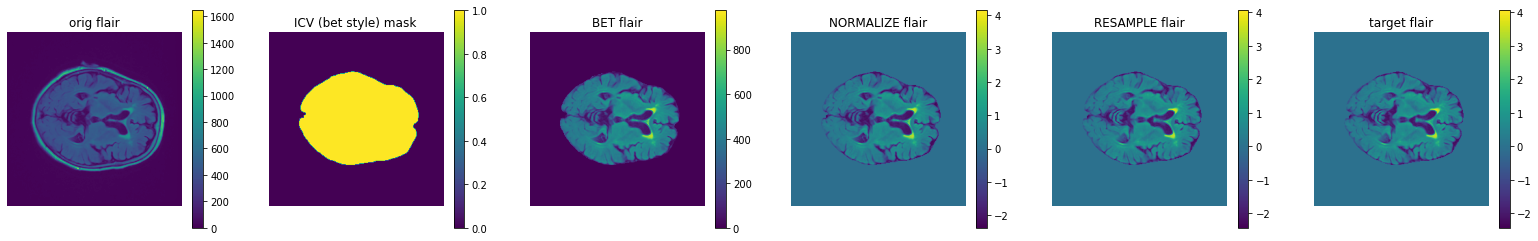

In [44]:
plt.figure(figsize=(32,4))
plt_img(orig_flair, "orig flair", [1,7,1], islice1)
plt_img(icv_mask, "ICV (bet style) mask", [1,7,2], islice1)
plt_img(imgs_dir + 'BET_CVD001_FLAIR.nii.gz', "BET flair", [1,7,3], islice1)
plt_img(imgs_dir + 'NORMALIZE_CVD001_FLAIR.nii.gz', "NORMALIZE flair", [1,7,4], islice1)
plt_img(imgs_dir + 'CVD001_FLAIR.nii.gz', "RESAMPLE flair", [1,7,5], islice2)
plt_img(target_flair, "target flair", [1,7,6], islice2)

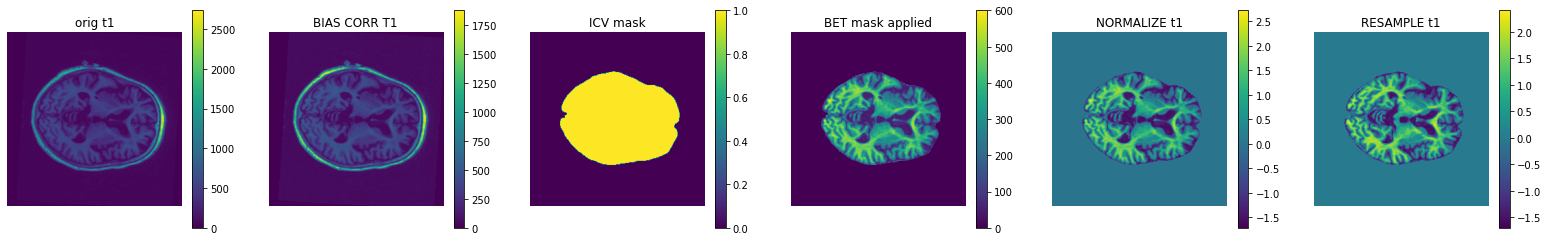

In [47]:
plt.figure(figsize=(32,4))
plt_img(orig_t1, "orig t1", [1,7,1], islice1)
plt_img(imgs_dir + "BIAS_CORR_CVD001_T1.nii.gz", "BIAS CORR T1", [1,7,2], islice1)
plt_img(icv_mask, "ICV mask", [1,7,3], islice1)
plt_img(imgs_dir + 'BET_CVD001_T1.nii.gz', "BET mask applied", [1,7,4], islice1)
plt_img(imgs_dir + 'NORMALIZE_CVD001_T1.nii.gz', "NORMALIZE t1", [1,7,5], islice1)
plt_img(imgs_dir + 'CVD001_T1.nii.gz', "RESAMPLE t1", [1,7,6], islice2)

In [36]:
img, _ = load_nii_img(imgs_dir + "BIAS_CORR_CVD001_T1.nii.gz")

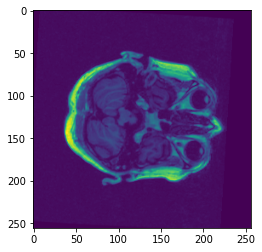

In [37]:
plt.imshow(img[:,:,20])

In [38]:
img.shape

(256, 256, 80)

In [39]:
resampled_flair, _ = load_nii_img(imgs_dir + 'CVD001_FLAIR.nii.gz')

In [42]:
resampled_flair.shape

(256, 256, 53)

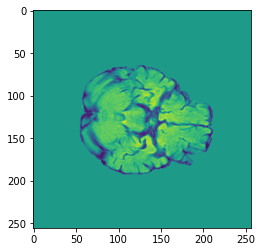

In [40]:
plt.imshow(resampled_flair[:,:,20])

In [30]:
# comparison to previously preprocessed flair:
prevprep = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/WMH_challenge_dataset/Utrecht/imgs/0_FLAIR.nii.gz"

In [31]:
prep_img, _ = load_nii_img(prevprep)

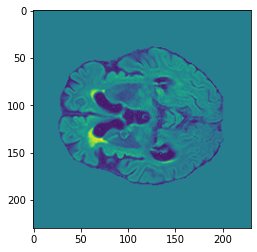

In [32]:
plt.imshow(prep_img[:,:,20])

In [33]:
target_prev, _ = load_nii_img(target_flair)

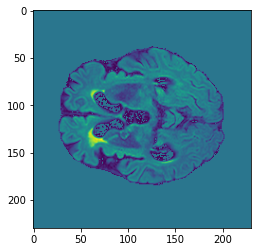

In [34]:
plt.imshow(target_prev[:,:,20])